In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import nltk
import pickle
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from gensim.utils import tokenize
from gensim.models import Phrases, Word2Vec

from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
#download necessary packages
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gangu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gangu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gangu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gangu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
path_data = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\DATA\\train_data.csv'
path_labels = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\DATA\\train_results.csv'
path_test_data = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\DATA\\test_data.csv'

In [4]:
data_df = pd.read_csv(path_data)
label_df = pd.read_csv(path_labels)
test_df = pd.read_csv(path_test_data)

In [5]:
df = pd.merge(data_df, label_df, on='id')

In [6]:
df

,id,text,target
0,0,Anyway Im getting of for a while,positive
1,1,"My red, Apache isn't feelin too well this morn...",negative
2,2,@danyelljoy you should be its great. friday w...,positive
3,3,its 11:30pm and i dont wanna sleep; so i debat...,positive
4,4,Why does twitter eat my DM's? Not happy,negative
...,...,...,...
1040318,1040318,getting ready 2 watch mental,positive
1040319,1040319,Wristcutters and Half Nelson are on Sundance F...,negative
1040320,1040320,@t_isfortammy Going out in Northbridge makes m...,negative
1040321,1040321,@iModel_ lol.... Gorgeous...lol! U look sooo m...,positive


## Pre-Process Train

#### Helper functions

In [7]:
class PreProc():
    def __init__(self):
        pass
        
    def remove_more_stop_words(self,words_arr):
        if (len(words_arr) > 0):
            remove = np.vectorize(lambda word: self.word_counts[word] >50)
            return words_arr[remove(words_arr)]
        else:
            return ['empty']

    #return low frequency words + words that don't appear in train
    def remove_more_stop_words_test(self,words_arr):
        if (len(words_arr) > 0):
            remove = np.vectorize(lambda word: False if not word in self.word_counts else (True if self.word_counts[word] >50 else False))
            return words_arr[remove(words_arr)]
        else:
            return ['empty']

    #find the correct wordnet tag for nltk pos_tag equivalent  
    def get_wordnet_pos(self,treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    #lemmatize 
    def lemmatize(self,word_list):
        pos_tag = nltk.pos_tag(list(word_list))
        words = [self.lemmatizer.lemmatize(i[0], self.get_wordnet_pos(i[1])) for i in pos_tag]
        return words    
        
    def preproc(self,df, is_test=False):
    
        feature_df = df.copy()
        #convert lower case
        feature_df['text'] = feature_df['text'].str.lower()
        #remove URLS
        feature_df['text'] = feature_df['text'].str.replace(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', '', regex=True)
        #remove mentions
        feature_df['text'] = feature_df['text'].str.replace(r'@([a-zA-Z0-9_]{1,50})', '', regex=True)
        #remove hashtags
        feature_df['text'] = feature_df['text'].str.replace(r'#([a-zA-Z0-9_]{1,50})', '', regex=True)
        #remove punctuations
        feature_df['text'] = feature_df['text'].str.replace(r'[^\w\s]', '', regex=True)
        #tokenize
        feature_df['text'] = feature_df['text'].apply(lambda x : np.asarray(list(tokenize(x))))

        if not is_test:
            #encode target labels 
            label_encoder = LabelEncoder()
            label_encoder.fit(feature_df['target'])
            feature_df['target'] = label_encoder.transform(feature_df['target'])
            #check word counts
            self.word_counts = feature_df.explode('text')['text'].value_counts().to_dict()
            #remove low frequency words
            feature_df['text'] = feature_df['text'].apply(self.remove_more_stop_words)

        elif is_test:
            feature_df['text'] = feature_df['text'].apply(self.remove_more_stop_words_test)

        #lemmatize
        self.lemmatizer = WordNetLemmatizer()
        feature_df['text'] = feature_df['text'].apply(self.lemmatize)

        if not is_test:
            #vocab
            vocabulary = feature_df.explode('text')['text'].value_counts().to_dict()
            #vocab length
            vocab_length = len(vocabulary)
            return feature_df, self.word_counts, vocabulary, vocab_length

        elif is_test:
            return feature_df
            
    

## Pre-Process data and save dataframe

In [10]:
preprocess = PreProc()
feature_df, word_counts, vocabulary, vocab_length = preprocess.preproc(df, is_test=False)
feature_df_test = preprocess.preproc(test_df, is_test=True)

In [2]:
path_df_SVM_train = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\Dataframe\\lemmatized_feature_df_SVM.pkl'
path_df_SVM_test = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\Dataframe\\lemmatized_feature_df_test_SVM.pkl'


In [3]:
#feature_df.to_pickle(path_df_SVM_train)
#feature_df_test.to_pickle(path_df_SVM_test)

In [4]:
#Uncomment and load dataframe if already pro-processed and saved
feature_df = pd.read_pickle(path_df_SVM_train)
feature_df_test = pd.read_pickle(path_df_SVM_test)

In [16]:
def tfidf(train_df, test_df):
    feature_df = train_df.copy()
    feature_df['text'] = feature_df['text'].str.join(' ')
    x_train_df, x_val_df = train_test_split(feature_df, stratify=feature_df['target'], random_state=40,test_size=0.2)
    v_c = TfidfVectorizer(max_features=90000)
    tfid_transformer = v_c.fit(x_train_df['text'])
    x_c = tfid_transformer.transform(x_train_df['text'])
    x_c_v = tfid_transformer.transform(x_val_df['text'])
    x_c = x_c.astype('float32')
    #x_c = x_c.toarray().astype('float32')
    x_c_v = x_c_v.astype('float32')
    #x_c_v = x_c_v.toarray().astype('float32')
    y_train = np.asarray(x_train_df['target'].tolist())
    y_val = np.asarray(x_val_df['target'].tolist())
    
    test_df['text'] = test_df['text'].str.join(' ')
    x_c_test = tfid_transformer.transform(test_df['text'])
    x_c_test = x_c_test.astype('float32')
    #x_c_test = x_c_test.todense().astype('float32')
    
    return x_c, x_c_v, y_train, y_val, x_c_test

In [17]:
x_c, x_c_v, y_train, y_val, x_c_test = tfidf(feature_df, feature_df_test)

In [11]:
def standardize(x_train, x_val, x_test):
    scaler = StandardScaler()
    scaler_fit = scaler.fit(x_train)
    x_train = scaler_fit.transform(x_train)
    
    x_val = scaler_fit.transform(x_val)
    x_test = scaler_fit.transform(x_c_test)
    return x_train, x_val, x_test

In [12]:
x_train, x_val, x_test = standardize(x_c, x_c_v, x_c_test)

ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

## Model SVM

In [18]:
def train_SVM(x, y):
    SVM_classifier_M = LinearSVC(random_state=40)
    model_SVM = SVM_classifier_M.fit(x, y)
    #path_models_SVM = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\Models\\SVM_classifier_new.pkl'
    #with open(path_models_SVM, 'wb') as f:
    #    pickle.dump(model_SVM, f)
    return model_SVM

In [19]:
model_SVM = train_SVM(x_c, y_train)

### Predict on val and get metrics

In [20]:
y_pred = model_SVM.predict(x_c_v)

In [21]:
acc = accuracy_score(y_val, y_pred)

In [22]:
cr = classification_report(y_val, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.79      0.77      0.78    103961
           1       0.00      0.00      0.00        17
           2       0.78      0.80      0.79    104087

    accuracy                           0.79    208065
   macro avg       0.52      0.52      0.52    208065
weighted avg       0.79      0.79      0.79    208065



C:\Users\gangu\.conda\envs\kaggle_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gangu\.conda\envs\kaggle_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gangu\.conda\envs\kaggle_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
cm = confusion_matrix(y_val, y_pred)
print(cm)

[[80546     0 23415]
 [    4     0    13]
 [20981     0 83106]]


In [24]:
def plot_cf(Y_true, Y_pred):
    cf = confusion_matrix(Y_true, Y_pred)
    plt.figure(figsize=(8,8))
    sb.heatmap(cf, annot=True, fmt="d", cmap='Blues')
    return None

Text(0.5, 1.0, 'Confusion Matrix for SVM')

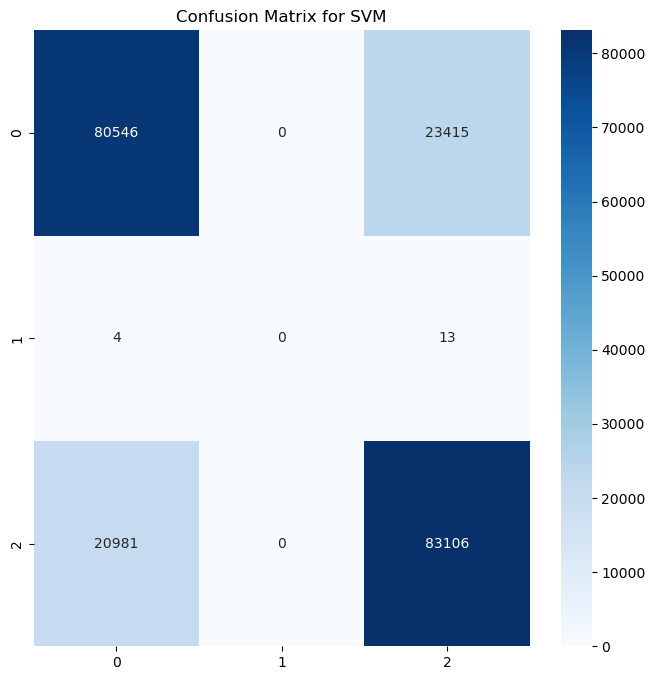

In [25]:
plot_cf(y_val, y_pred)
plt.title("Confusion Matrix for SVM")

### RBF

In [8]:
def train_SVM(x, y):
    SVM_classifier_M = SVC(random_state=40,max_iter=5000)
    model_SVM = SVM_classifier_M.fit(x, y)
    #path_models_SVM = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\Models\\SVM_classifier_new.pkl'
    #with open(path_models_SVM, 'wb') as f:
    #    pickle.dump(model_SVM, f)
    return model_SVM

In [ ]:
model_SVM = train_SVM(x_c, y_train)

In [ ]:
y_pred = model_SVM.predict(x_c_v)

In [ ]:
acc = accuracy_score(y_val, y_pred)

In [ ]:
cr = classification_report(y_val, y_pred)
print(cr)

In [ ]:
cm = confusion_matrix(y_val, y_pred)
print(cm)

## Test

In [23]:
y_pred_test = model_SVM.predict(x_test)
#y_pred_classes = np.argmax(y_pred_test, axis=1)

In [24]:
predictions_df = pd.DataFrame(y_pred_test, columns=['target'])
predictions_df.index.name = 'id'

In [25]:
predictions_df

,target
id,
0,0
1,2
2,2
3,2
4,0
...,...
560170,0
560171,0
560172,0


In [26]:
path_output = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\Test_output\\test_results_SVM.csv'

In [27]:
predictions_df.to_csv(path_output, index=True, index_label='id')

### References

- https://arxiv.org/pdf/1310.4546.pdf
- https://stackoverflow.com/questions/34721984/stopword-removing-when-using-the-word2vec
- https://radimrehurek.com/gensim/models/word2vec.html